In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd



Loading and processing the training data

In [2]:
# load the csv file lab, display head to examine
train_file = 'train.csv'
train_csv = pd.read_csv(train_file)
# randomize dataframe rows to prepare for dividing into train/valid/test sets
data = train_csv.sample(frac = 1)
# display for a quick check
data.head()


,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
340,559,Populus_Adenopoda,0.019531,0.021484,0.062500,0.019531,0.003906,0.019531,0.080078,0.0,...,0.000000,0.000000,0.003906,0.014648,0.000000,0.11231,0.000000,0.272460,0.000000,0.000000
520,841,Quercus_Coccinea,0.001953,0.000000,0.037109,0.048828,0.007812,0.000000,0.001953,0.0,...,0.005859,0.008789,0.016602,0.002930,0.014648,0.00000,0.002930,0.012695,0.004883,0.000000
356,588,Eucalyptus_Neglecta,0.066406,0.121090,0.015625,0.001953,0.000000,0.160160,0.023438,0.0,...,0.039062,0.000000,0.021484,0.006836,0.016602,0.00000,0.000000,0.012695,0.000000,0.076172
164,288,Acer_Mono,0.023438,0.007812,0.027344,0.035156,0.003906,0.005859,0.019531,0.0,...,0.182620,0.000000,0.016602,0.000000,0.002930,0.00000,0.000000,0.000000,0.000000,0.007812
909,1461,Cornus_Chinensis,0.068359,0.158200,0.021484,0.000000,0.000000,0.109380,0.005859,0.0,...,0.000000,0.083008,0.006836,0.004883,0.014648,0.00000,0.004883,0.038086,0.003906,0.033203


In [4]:
#get the different species categories
categories = train_csv.species.unique()
#print the 1st 10 to verify
print "First 10 categories: ", categories[:10]
#print length of array to ensure 99 categories are there
print "Number of categories:", len(categories) 
print type(categories)

#convert string categories for training set into indices of the categories array
labels_dense = [np.where(i == categories)[0][0] for i in data.species]

#convert dense labels to one-hot-encoding
labels = np.eye(len(categories))[labels_dense]

First 10 categories:  ['Acer_Opalus' 'Pterocarya_Stenoptera' 'Quercus_Hartwissiana'
 'Tilia_Tomentosa' 'Quercus_Variabilis' 'Magnolia_Salicifolia'
 'Quercus_Canariensis' 'Quercus_Rubra' 'Quercus_Brantii' 'Salix_Fragilis']
Number of categories: 99
<type 'numpy.ndarray'>


Split the data into training, test, and validation sets

In [5]:
# split into train/test datasets. 
# test here means my own private test set to get my own idea of the accuracy, not the given test set
train_length = int(len(data) * .8)

train_ = data[:train_length]
test_data = data[train_length:]
print("Total data: {} Training and validation examples: {} Test examples: {}".format(len(data), len(train_), len(test_data)))
train_l = labels[:train_length]
test_labels = labels[train_length:]
print("Total labels: {} Training and validation labels: {} Test labelss: {}".format(len(labels), len(train_l), len(test_labels)))

#further split training data and labels into training and validation sets

train_length = int(len(train_) * .8)

train_data = train_[:train_length]
valid_data = train_[train_length:]
print("Total Training and validation examples: {} Training examples: {} Validation examples: {}".format(len(train_), len(train_data), len(valid_data)))
train_labels = train_l[:train_length]
valid_labels = train_l[train_length:]
print("Total Training and validationl labels: {} Training labels: {} Validation labels: {}".format(len(train_l), len(train_labels), len(valid_labels)))
print("Shape of training labels: {}".format(train_labels.shape))

Total data: 990 Training and validation examples: 792 Test examples: 198
Total labels: 990 Training and validation labels: 792 Test labelss: 198
Total Training and validation examples: 792 Training examples: 633 Validation examples: 159
Total Training and validationl labels: 792 Training labels: 633 Validation labels: 159
Shape of training labels: (633, 99)


Now for the image data: I will grab the image for all the ids in the training and test set, coverting them from jpg to binary.

In [6]:
images = []
for i in train_csv.id:
    im_gray = cv2.imread('images/' + str(i) + ".jpg", cv2.IMREAD_GRAYSCALE)
    thres, im_bw = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    im_bw = np.array(im_bw)
    images.append(im_bw)

 # conversion to binary courtesy of  http://stackoverflow.com/a/7637687/399741

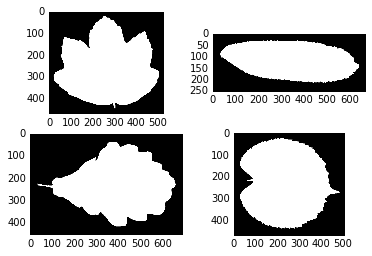

In [7]:
#visualize a few examples, visually verify with images in folder
fig = plt.figure()
counter = 1
for ima in images[:4]:
    a = fig.add_subplot(2,2, counter)
    plt.imshow(ima, cmap='gray')
    counter +=1
    

Need to make all the images the same size to run a CNN. Since CNNs are location invariant, preserving image shape is more important than centering it or preserving its location. So I will add black pixeles to the top and right edges of the image matrices so that they are of uniform size.

In [27]:
# get the max height and width of all the images in the image dataset
max_height = 0
max_width = 0

for i in images:
    if i.shape[0] > max_height:
        max_height = i.shape[0]
    if i.shape[1] > max_width:
        max_width = i.shape[1]
        
print "Max image height: ", max_height
print "Max image width: ", max_width

def add_padding(image, width, height):
    add_top = height - image.shape[0]
    add_right = width - image.shape[1]
    npad = ((0, add_top), (0, add_right))
    return np.pad(image, pad_width=npad, mode='constant', constant_values=0)
   
images_padded = np.array([add_padding(i, max_width, max_height) for i in images])
print images_padded[5].shape

Max image height:  1089
Max image width:  1633
(1089, 1633)


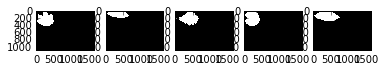

In [28]:
#visualize a few examples, visually verify that padding was added
fig = plt.figure()
counter = 1
for ima in images_padded[:5]:
    a = fig.add_subplot(1,5, counter)
    plt.imshow(ima, cmap='gray')
    counter +=1
    